# Data Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df_train = pd.read_csv("NN_TRAIN/data.csv")
df_test = pd.read_csv("NN_TEST/data.csv")

In [3]:
df_train

,Unnamed: 0,Labels
0,0,DZMITRY LESZCZYŃSKI
1,0,CYPRIAN KUROWSKI
2,0,MARZENNA KĘDZIERSKA
3,0,JOWITA NOWAKOWSKA
4,0,NIKODEM WALCZAK
...,...,...
9995,0,DORIAN KLIMEK
9996,0,VIOLETTA SOBCZAK
9997,0,OLGA GÓRECKA
9998,0,ARTEM NAWROCKI


In [4]:
img_height = 128
img_width = 496

In [5]:
x_train =[]
y_train = []
x_test = []
y_test = []

In [6]:
path = "NN_TRAIN/"
for i in range(len(df_train)):
    x_train.append(path+f"img_{i}.jpg")
    y_train.append(df_train.iloc[i]["Labels"].lower())
    

In [7]:
path = "NN_TEST/"
for i in range(len(df_test)):
    x_test.append(path+f"img_{i}.jpg")
    y_test.append(df_test.iloc[i]["Labels"].lower())

# Data Preparation


In [8]:
characters = ['a', 'ą', 'b', 'c', 'ć', 'd', 'e', 'ę', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'ł',
              'm', 'n', 'ń', 'o', 'ó', 'p', 'r', 's', 'ś', 't', 'u', 'w', 'y', 'z', 'ź', 'ż',' ']
batch_size = 16
max_len = max([len(label) for label in y_train])

In [9]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=1, mask_token=None
)
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), mask_token=None, invert=True,num_oov_indices=1
)

In [10]:
temp = char_to_num(["j","0","n"])
print (temp)
temp = num_to_char(temp)
print (temp)

tf.Tensor([13  0 18], shape=(3,), dtype=int64)
tf.Tensor([b'j' b'[UNK]' b'n'], shape=(3,), dtype=string)


In [11]:
print(x_train[0],y_train[0])

NN_TRAIN/img_0.jpg dzmitry leszczyński


In [12]:
for i in range(len(y_train)):
    for j in range(max_len-len(y_train[i])):
        y_train[i]+="0"
for i in range(len(y_test)):
    for j in range(max_len-len(y_test[i])):
        y_test[i]+="0"
for i in range(10):
    print(y_train[i])
    print(len(y_train[i]))
print(min([len(label) for label in y_train]))

dzmitry leszczyński000000
25
cyprian kurowski000000000
25
marzenna kędzierska000000
25
jowita nowakowska00000000
25
nikodem walczak0000000000
25
juliusz grabowski00000000
25
ruslan kędzierski00000000
25
mariusz jasiński000000000
25
krzysztof górski000000000
25
leszek wojciechowski00000
25
25


In [13]:
char_to_num(tf.strings.unicode_split("test", input_encoding="UTF-8"))

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([26,  7, 24, 26], dtype=int64)>

In [14]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    #print(label)
    #label = pad_sequences([label], maxlen=max_len, padding='post', dtype='int32')
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [16]:
train_dataset.take(1)

<TakeDataset element_spec={'image': TensorSpec(shape=(None, 496, 128, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

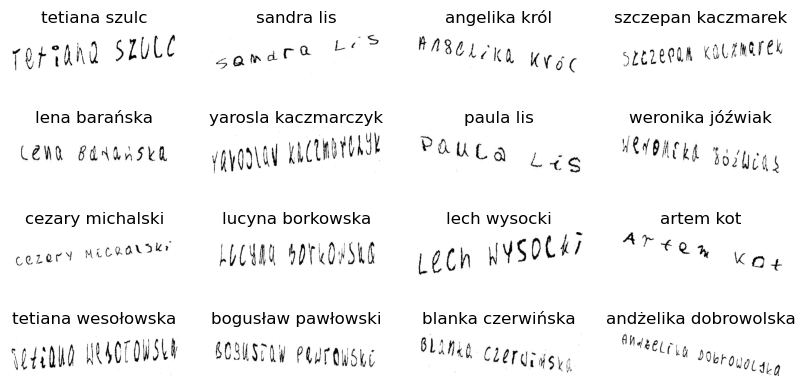

In [17]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in validation_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        label = label.replace("[UNK]","")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Building and Training

In [18]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred



In [19]:
def model1():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 2, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

In [20]:
model1 = model1()
epochs = 150
early_stopping_patience = 25
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model1.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/150
625/625 [==============================] - 55s 75ms/step - loss: 52.4627 - val_loss: 46.2510
Epoch 2/150
625/625 [==============================] - 46s 74ms/step - loss: 43.9281 - val_loss: 41.3935
Epoch 3/150
625/625 [==============================] - 47s 75ms/step - loss: 40.5807 - val_loss: 39.2454
Epoch 4/150
625/625 [==============================] - 50s 81ms/step - loss: 39.2527 - val_loss: 38.2054
Epoch 5/150
625/625 [==============================] - 52s 83ms/step - loss: 38.4809 - val_loss: 37.8338
Epoch 6/150
625/625 [==============================] - 54s 86ms/step - loss: 37.8508 - val_loss: 36.5506
Epoch 7/150
625/625 [==============================] - 53s 84ms/step - loss: 37.7544 - val_loss: 38.0416
Epoch 8/150
625/625 [==============================] - 53s 84ms/step - loss: 37.4841 - val_loss: 36.5653
Epoch 9/150
625/625 [==============================] - 56s 89ms/step - loss: 37.3034 - val_loss: 36.0187
Epoch 10/150
625/625 [==============================] -

625/625 [==============================] - 65s 104ms/step - loss: 6.9165 - val_loss: 5.9037
Epoch 79/150
625/625 [==============================] - 65s 105ms/step - loss: 7.4308 - val_loss: 7.1372
Epoch 80/150
625/625 [==============================] - 68s 108ms/step - loss: 6.6146 - val_loss: 5.8643
Epoch 81/150
625/625 [==============================] - 67s 107ms/step - loss: 6.3668 - val_loss: 5.4655
Epoch 82/150
625/625 [==============================] - 63s 101ms/step - loss: 5.8582 - val_loss: 5.4745
Epoch 83/150
625/625 [==============================] - 66s 106ms/step - loss: 6.5755 - val_loss: 5.4167
Epoch 84/150
625/625 [==============================] - 67s 106ms/step - loss: 6.5144 - val_loss: 5.6874
Epoch 85/150
625/625 [==============================] - 65s 103ms/step - loss: 5.9611 - val_loss: 5.4195
Epoch 86/150
625/625 [==============================] - 67s 107ms/step - loss: 8.7982 - val_loss: 8.1931
Epoch 87/150
625/625 [==============================] - 68s 109ms/st

# Model Testing

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 496, 128, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 496, 128, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 248, 64, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 248, 64, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 124, 32, 64)       0         
                                                                 
 reshape (Reshape)           (None, 124, 2048)         0         
                                                                 
 dense1 (Dense)              (None, 124, 64)           131136

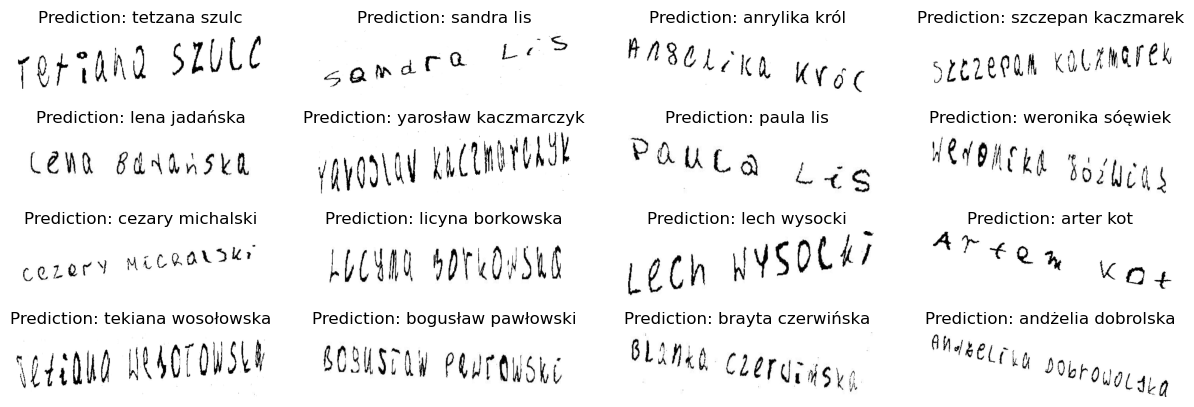

In [21]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model1.get_layer(name="image").input, model1.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        #print("Results")
        #print(res)
        #print(num_to_char(res))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    for i in range(len(pred_texts)):
        pred_texts[i]=pred_texts[i].replace("[UNK]","")
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [35]:
prediction_model.compile(optimizer='adam')

In [36]:
prediction_model.save("model.keras")